In [1]:
"""
Notebook de Vérification - Vectorisation Baseline GMM + TF-IDF
================================================================
Ce notebook permet de vérifier et analyser les résultats de la vectorisation baseline.
"""
import pickle
import networkx as nx

print(" NOTEBOOK DE VÉRIFICATION - VECTORISATION BASELINE")

#%% 1. CHARGEMENT DES DONNÉES
print("\n 1. CHARGEMENT DES DONNÉES")

# Chemin vers votre fichier .pkl
graph_path = "../data/04_feature/baseline_vectorized_graph.pkl" 

try:
    with open(graph_path, 'rb') as f:
        vectorized_graph = pickle.load(f)  # ← Le contenu du fichier
    
    print(f"Graphe chargé avec succès")
    print(f"   Type: {type(vectorized_graph)}")  # ← Afficher le type du CONTENU, pas du chemin
    
    # Vérifications supplémentaires
    if isinstance(vectorized_graph, nx.MultiDiGraph):
        print(f"   Nombre de nœuds: {vectorized_graph.number_of_nodes()}")
        print(f"   Nombre d'arêtes: {vectorized_graph.number_of_edges()}")
        
        # Vérifier les embeddings
        sample_node = list(vectorized_graph.nodes())[0]
        if 'embedding' in vectorized_graph.nodes[sample_node]:
            embedding = vectorized_graph.nodes[sample_node]['embedding']
            print(f"   Embedding trouvé - Type: {type(embedding)}, Shape: {embedding.shape}")
        else:
            print("   ATTENTION: Pas d'embedding trouvé dans les nœuds")
    else:
        print(f"   ERREUR: Type inattendu - {type(vectorized_graph)}")
        
except FileNotFoundError:
    print("Fichier non trouvé. Veuillez ajuster le chemin 'graph_path'")
except Exception as e:
    print(f"Erreur lors du chargement: {e}")

 NOTEBOOK DE VÉRIFICATION - VECTORISATION BASELINE

 1. CHARGEMENT DES DONNÉES
Graphe chargé avec succès
   Type: <class 'networkx.classes.multidigraph.MultiDiGraph'>
   Nombre de nœuds: 145341
   Nombre d'arêtes: 678839
   Embedding trouvé - Type: <class 'numpy.ndarray'>, Shape: (64,)


In [2]:
#%% 2. EXTRACTION DES EMBEDDINGS
import numpy as np
from collections import Counter
print("\n 2. EXTRACTION DES EMBEDDINGS")

# Extraire tous les embeddings des nœuds
node_embeddings = []
node_methods = []
node_ids = []

for node_id, attrs in vectorized_graph.nodes(data=True):
    if 'embedding' in attrs:
        node_embeddings.append(attrs['embedding'])
        node_methods.append(attrs.get('encoding_method', 'Unknown'))
        node_ids.append(node_id)

# Extraire tous les embeddings des arêtes
edge_embeddings = []
edge_methods = []
edge_ids = []

for u, v, attrs in vectorized_graph.edges(data=True):
    if 'embedding' in attrs:
        edge_embeddings.append(attrs['embedding'])
        edge_methods.append(attrs.get('encoding_method', 'Unknown'))
        edge_ids.append(f"{u}->{v}")

# Conversion en arrays numpy
node_embeddings = np.array(node_embeddings)
edge_embeddings = np.array(edge_embeddings)

print(f" Nœuds avec embeddings: {len(node_embeddings):,}")
print(f" Arêtes avec embeddings: {len(edge_embeddings):,}")
print(f" Dimension des embeddings: {node_embeddings.shape[1] if len(node_embeddings) > 0 else 'N/A'}")

# Statistiques des méthodes d'encodage
node_method_counts = Counter(node_methods)
edge_method_counts = Counter(edge_methods)

print(f"\n Méthodes d'encodage - Nœuds:")
for method, count in node_method_counts.items():
    print(f"   {method}: {count:,} ({count/len(node_methods)*100:.1f}%)")

print(f"\n Méthodes d'encodage - Arêtes:")
for method, count in edge_method_counts.items():
    print(f"   {method}: {count:,} ({count/len(edge_methods)*100:.1f}%)")



 2. EXTRACTION DES EMBEDDINGS
 Nœuds avec embeddings: 145,341
 Arêtes avec embeddings: 678,839
 Dimension des embeddings: 64

 Méthodes d'encodage - Nœuds:
   WORD2VEC_WEIGHTED: 61,205 (42.1%)
   IP_ADDRESS: 441 (0.3%)
   TIMESTAMP: 82,949 (57.1%)
   GMM: 746 (0.5%)

 Méthodes d'encodage - Arêtes:
   WORD2VEC_WEIGHTED: 678,839 (100.0%)


In [3]:
#%% 3. ANALYSE STATISTIQUE DES EMBEDDINGS
print("\n 3. ANALYSE STATISTIQUE DES EMBEDDINGS")

def analyze_embeddings(embeddings, name):
    """Analyse statistique complète des embeddings"""
    print(f"\n {name}")
    print(f"   Shape: {embeddings.shape}")
    print(f"   Min: {embeddings.min():.4f}")
    print(f"   Max: {embeddings.max():.4f}")
    print(f"   Mean: {embeddings.mean():.4f}")
    print(f"   Std: {embeddings.std():.4f}")
    print(f"   Médiane: {np.median(embeddings):.4f}")
    
    # Pourcentage de valeurs nulles
    zero_percentage = (embeddings == 0).sum() / embeddings.size * 100
    print(f"   % valeurs nulles: {zero_percentage:.2f}%")
    
    # Nombre de dimensions avec variance très faible
    dim_variances = np.var(embeddings, axis=0)
    low_var_dims = (dim_variances < 1e-6).sum()
    print(f"   Dimensions à faible variance: {low_var_dims}/{embeddings.shape[1]}")
    
    return {
        'mean': embeddings.mean(),
        'std': embeddings.std(),
        'min': embeddings.min(),
        'max': embeddings.max(),
        'median': np.median(embeddings),
        'zero_percentage': zero_percentage,
        'low_var_dims': low_var_dims,
        'dim_variances': dim_variances
    }

node_stats = analyze_embeddings(node_embeddings, "EMBEDDINGS NŒUDS")
edge_stats = analyze_embeddings(edge_embeddings, "EMBEDDINGS ARÊTES")


 3. ANALYSE STATISTIQUE DES EMBEDDINGS

 EMBEDDINGS NŒUDS
   Shape: (145341, 64)
   Min: -4.7653
   Max: 22.2996
   Mean: 0.0485
   Std: 0.2304
   Médiane: 0.0002
   % valeurs nulles: 0.11%
   Dimensions à faible variance: 0/64

 EMBEDDINGS ARÊTES
   Shape: (678839, 64)
   Min: -2.5156
   Max: 2.5299
   Mean: -0.0104
   Std: 0.6486
   Médiane: 0.0002
   % valeurs nulles: 0.00%
   Dimensions à faible variance: 0/64


In [4]:
# Trouvez quelle valeur originale cause Max=19.6
max_pos = np.where(node_embeddings == node_embeddings.max())
if len(max_pos[0]) > 0:
    problematic_node_idx = max_pos[0][0]
    node_list = list(vectorized_graph.nodes())
    problematic_node = node_list[problematic_node_idx]
    
    print(f"Valeur Max {node_embeddings.max():.3f} :")
    print(f"  Nœud: {problematic_node}")
    print(f"  Label: {vectorized_graph.nodes[problematic_node].get('label')}")
    print(f"  Méthode: {vectorized_graph.nodes[problematic_node].get('encoding_method')}")

Valeur Max 22.300 :
  Nœud: 207
  Label: 20893
  Méthode: GMM


GENERATION DES GRAPHIQUES DE VALIDATION


C:\Users\TACKIACADEMY\AppData\Local\Temp\ipykernel_10864\1507264863.py:130: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(method_data, labels=method_labels, patch_artist=True,


Graphiques sauvegardes: validation_vectorisation.png


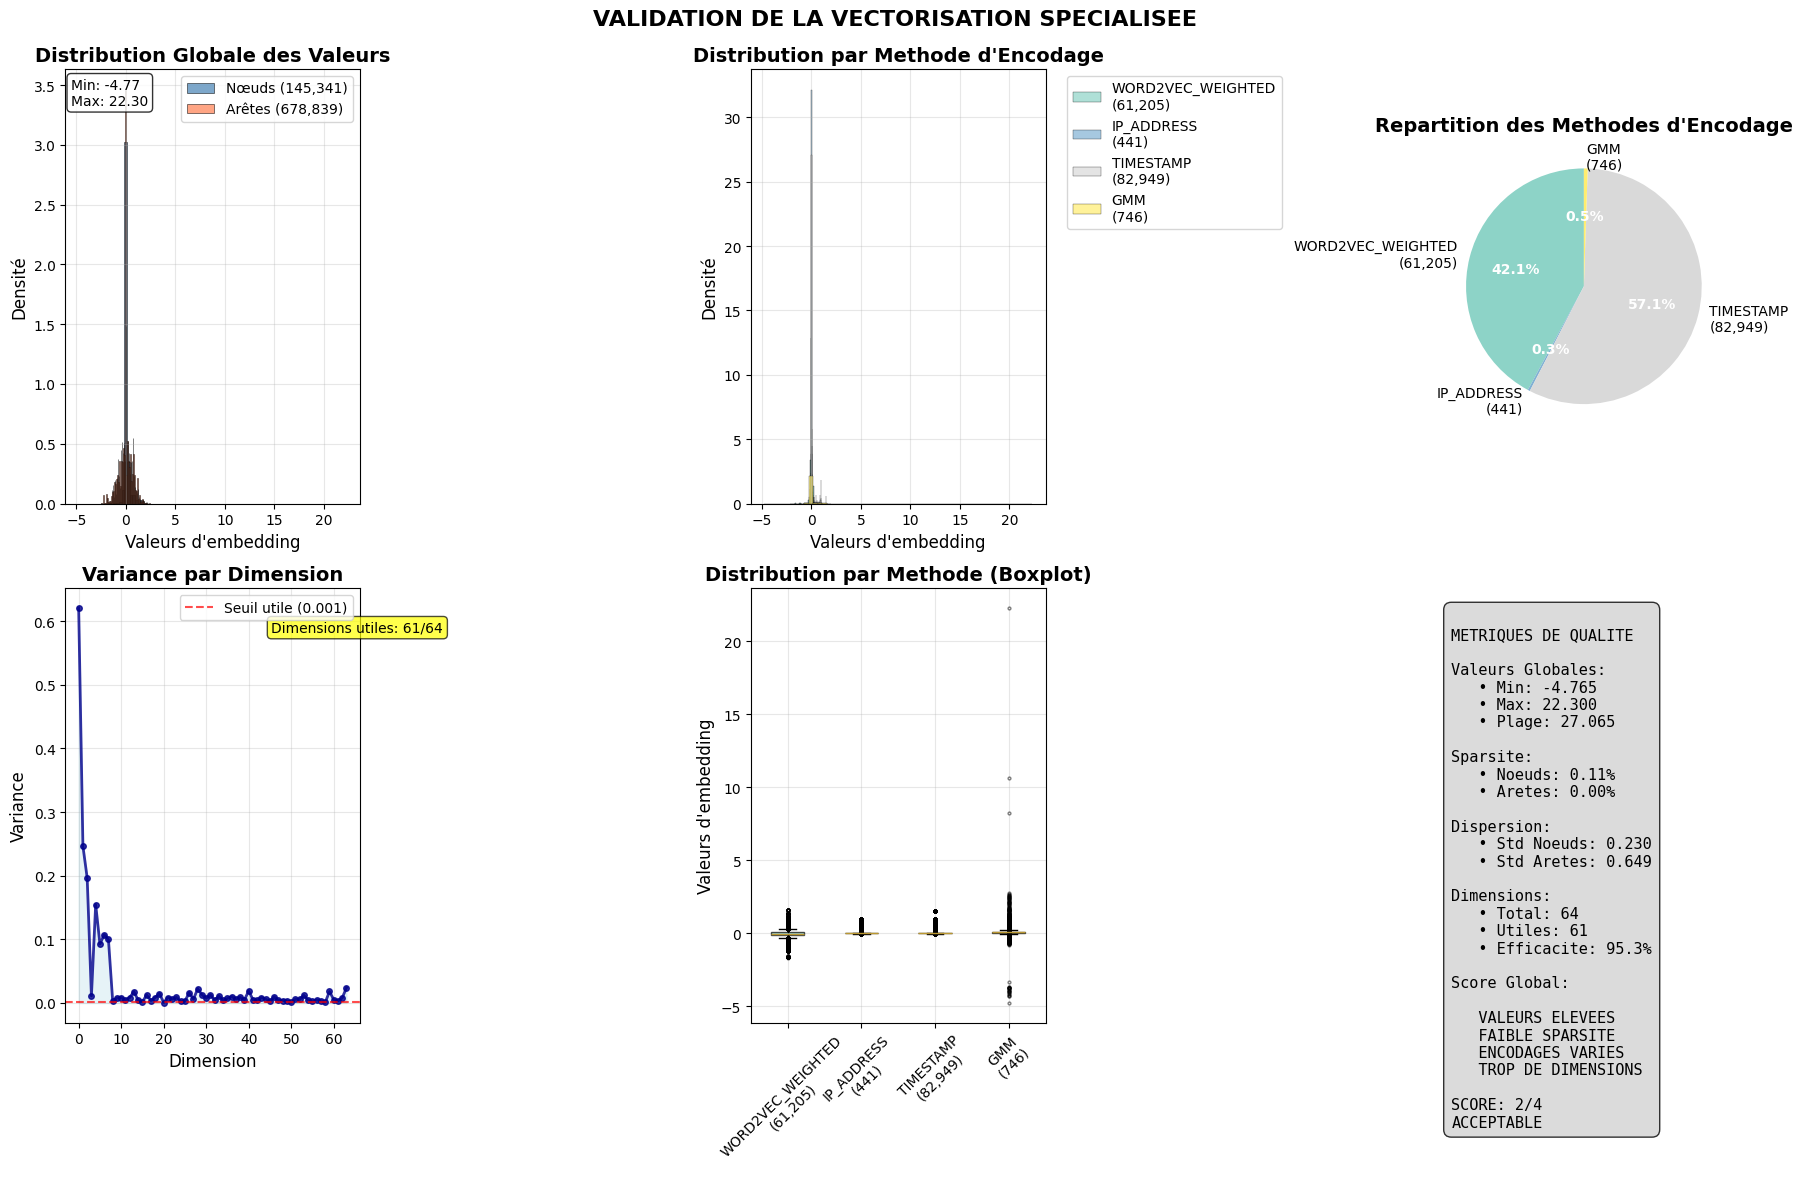


RESUME DE LA VALIDATION
Donnees: 145,341 noeuds, 678,839 aretes
Dimensions: 64 (dont 61 utiles)
Methodes: 4 types d'encodage
Qualite: Max=22.30, Sparsite=0.1%
Score: 2/4
Ameliorations recommandees avant ML


In [5]:
"""
Graphiques de validation propres pour la vectorisation
"""

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Configuration des graphiques
plt.style.use('default')
sns.set_palette("husl")

print("GENERATION DES GRAPHIQUES DE VALIDATION")

# Extraire les données nécessaires
node_embeddings = np.array([attrs['embedding'] for _, attrs in vectorized_graph.nodes(data=True)])
edge_embeddings = np.array([attrs['embedding'] for u, v, attrs in vectorized_graph.edges(data=True)])
node_methods = [attrs.get('encoding_method', 'Unknown') for _, attrs in vectorized_graph.nodes(data=True)]
edge_methods = [attrs.get('encoding_method', 'Unknown') for u, v, attrs in vectorized_graph.edges(data=True)]

# Compter les méthodes
node_method_counts = Counter(node_methods)
edge_method_counts = Counter(edge_methods)

# Créer la figure avec 6 graphiques
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('VALIDATION DE LA VECTORISATION SPECIALISEE', fontsize=16, fontweight='bold')

# 1. Distribution globale des valeurs
axes[0, 0].hist(node_embeddings.flatten(), bins=100, alpha=0.7, color='steelblue', 
               density=True, label=f'Nœuds ({len(node_embeddings):,})', edgecolor='black', linewidth=0.5)
axes[0, 0].hist(edge_embeddings.flatten(), bins=100, alpha=0.7, color='coral', 
               density=True, label=f'Arêtes ({len(edge_embeddings):,})', edgecolor='black', linewidth=0.5)

axes[0, 0].set_xlabel('Valeurs d\'embedding', fontsize=12)
axes[0, 0].set_ylabel('Densité', fontsize=12)
axes[0, 0].set_title('Distribution Globale des Valeurs', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Ajouter statistiques sur le graphique
max_val = max(node_embeddings.max(), edge_embeddings.max())
min_val = min(node_embeddings.min(), edge_embeddings.min())
axes[0, 0].text(0.02, 0.98, f'Min: {min_val:.2f}\nMax: {max_val:.2f}', 
                transform=axes[0, 0].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Distribution par méthode d'encodage (nœuds)
methods = list(node_method_counts.keys())
colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))

for i, method in enumerate(methods):
    method_mask = np.array(node_methods) == method
    if method_mask.sum() > 0:
        method_embeddings = node_embeddings[method_mask]
        axes[0, 1].hist(method_embeddings.flatten(), bins=60, alpha=0.7, 
                       density=True, label=f'{method}\n({method_mask.sum():,})', 
                       color=colors[i], edgecolor='black', linewidth=0.3)

axes[0, 1].set_xlabel('Valeurs d\'embedding', fontsize=12)
axes[0, 1].set_ylabel('Densité', fontsize=12)
axes[0, 1].set_title('Distribution par Methode d\'Encodage', fontsize=14, fontweight='bold')
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 1].grid(True, alpha=0.3)

# 3. Camembert des méthodes d'encodage
method_names = []
method_values = []
method_colors = []

for i, (method, count) in enumerate(node_method_counts.items()):
    method_names.append(f'{method}\n({count:,})')
    method_values.append(count)
    method_colors.append(colors[i])

wedges, texts, autotexts = axes[0, 2].pie(method_values, labels=method_names, autopct='%1.1f%%', 
                                         startangle=90, colors=method_colors,
                                         textprops={'fontsize': 10})

axes[0, 2].set_title('Repartition des Methodes d\'Encodage', fontsize=14, fontweight='bold')

# Améliorer la lisibilité
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 4. Variance par dimension
dim_variances = np.var(node_embeddings, axis=0)
dims = range(len(dim_variances))

axes[1, 0].plot(dims, dim_variances, 'o-', color='darkblue', linewidth=2, markersize=4, alpha=0.8)
axes[1, 0].fill_between(dims, dim_variances, alpha=0.3, color='lightblue')
axes[1, 0].set_xlabel('Dimension', fontsize=12)
axes[1, 0].set_ylabel('Variance', fontsize=12)
axes[1, 0].set_title('Variance par Dimension', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Ajouter ligne de seuil
variance_threshold = 0.001
axes[1, 0].axhline(y=variance_threshold, color='red', linestyle='--', alpha=0.7, 
                  label=f'Seuil utile ({variance_threshold})')
useful_dims = (dim_variances > variance_threshold).sum()
axes[1, 0].text(0.7, 0.9, f'Dimensions utiles: {useful_dims}/{len(dims)}', 
                transform=axes[1, 0].transAxes, 
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
axes[1, 0].legend()

# 5. Boxplot par méthode d'encodage
method_data = []
method_labels = []
box_colors = []

for i, method in enumerate(methods):
    method_mask = np.array(node_methods) == method
    if method_mask.sum() > 0:
        method_embeddings = node_embeddings[method_mask]
        # Échantillonner pour le boxplot
        sample_size = min(2000, len(method_embeddings))
        if len(method_embeddings) > sample_size:
            sample_indices = np.random.choice(len(method_embeddings), sample_size, replace=False)
            method_sample = method_embeddings[sample_indices].flatten()
        else:
            method_sample = method_embeddings.flatten()
        
        method_data.append(method_sample)
        method_labels.append(f'{method}\n({method_mask.sum():,})')
        box_colors.append(colors[i])

bp = axes[1, 1].boxplot(method_data, labels=method_labels, patch_artist=True, 
                       showfliers=True, flierprops=dict(marker='o', markersize=2, alpha=0.5))

# Colorer les boîtes
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1, 1].set_ylabel('Valeurs d\'embedding', fontsize=12)
axes[1, 1].set_title('Distribution par Methode (Boxplot)', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# 6. Métriques de qualité
axes[1, 2].axis('off')  # Supprimer les axes pour le tableau de métriques

# Calculer les métriques
max_global = max(node_embeddings.max(), edge_embeddings.max())
min_global = min(node_embeddings.min(), edge_embeddings.min())
sparsity_nodes = (node_embeddings == 0).sum() / node_embeddings.size * 100
sparsity_edges = (edge_embeddings == 0).sum() / edge_embeddings.size * 100
std_nodes = node_embeddings.std()
std_edges = edge_embeddings.std()

# Créer le tableau de métriques
metrics_text = f"""
METRIQUES DE QUALITE

Valeurs Globales:
   • Min: {min_global:.3f}
   • Max: {max_global:.3f}
   • Plage: {max_global - min_global:.3f}

Sparsite:
   • Noeuds: {sparsity_nodes:.2f}%
   • Aretes: {sparsity_edges:.2f}%

Dispersion:
   • Std Noeuds: {std_nodes:.3f}
   • Std Aretes: {std_edges:.3f}

Dimensions:
   • Total: {node_embeddings.shape[1]}
   • Utiles: {useful_dims}
   • Efficacite: {useful_dims/node_embeddings.shape[1]*100:.1f}%

Score Global:
"""

# Évaluation automatique
score = 0
if max_global < 5.0:
    score += 1
    metrics_text += "\n   VALEURS STABLES"
else:
    metrics_text += "\n   VALEURS ELEVEES"

if sparsity_nodes < 5.0:
    score += 1
    metrics_text += "\n   FAIBLE SPARSITE"
else:
    metrics_text += "\n   SPARSITE ELEVEE"

if len(set(node_methods)) > 1:
    score += 1
    metrics_text += "\n   ENCODAGES VARIES"
else:
    metrics_text += "\n   ENCODAGE UNIQUE"

if useful_dims < node_embeddings.shape[1] * 0.5:
    score += 1
    metrics_text += "\n   BON USAGE DIMENSIONS"
else:
    metrics_text += "\n   TROP DE DIMENSIONS"

metrics_text += f"\n\nSCORE: {score}/4"

if score == 4:
    metrics_text += "\nEXCELLENT !"
elif score >= 3:
    metrics_text += "\nTRES BON"
elif score >= 2:
    metrics_text += "\nACCEPTABLE"
else:
    metrics_text += "\nA AMELIORER"

axes[1, 2].text(0.05, 0.95, metrics_text, transform=axes[1, 2].transAxes, 
                fontsize=11, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

# Ajustement final
plt.tight_layout()
plt.subplots_adjust(top=0.93)

# Sauvegarder
plt.savefig('validation_vectorisation.png', dpi=300, bbox_inches='tight')
print("Graphiques sauvegardes: validation_vectorisation.png")
plt.show()

# Résumé textuel
print("\n" + "="*60)
print("RESUME DE LA VALIDATION")
print("="*60)
print(f"Donnees: {len(node_embeddings):,} noeuds, {len(edge_embeddings):,} aretes")
print(f"Dimensions: {node_embeddings.shape[1]} (dont {useful_dims} utiles)")
print(f"Methodes: {len(set(node_methods))} types d'encodage")
print(f"Qualite: Max={max_global:.2f}, Sparsite={sparsity_nodes:.1f}%")
print(f"Score: {score}/4")

if score >= 3:
    print("VECTORISATION VALIDEE - Prete pour ML !")
else:
    print("Ameliorations recommandees avant ML")

print("="*60)